In [1]:
import os.path as osp
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

In [2]:
from snorkel.models import candidate_subclass

InducingCytokine = candidate_subclass('InducingCytokine', ['cytokine', 'cell_type'])
train_cands = session.query(InducingCytokine).filter(InducingCytokine.split == 0).all()
dev_cands = session.query(InducingCytokine).filter(InducingCytokine.split == 1).all()

In [3]:
len(train_cands), len(dev_cands)

(8011, 168)

In [4]:
from snorkel.annotations import load_marginals
train_marginals = load_marginals(session, split=0)

In [5]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1, load_as_array=True)
L_gold_dev = np.where(L_gold_dev == 1, 1, -1)
assert np.all(np.in1d(L_gold_dev, [-1, 1]))
L_gold_dev.shape

(168,)

In [6]:
train_marginals.shape, train_marginals.min(), train_marginals.max()

((8011,), 0.04156114398378925, 0.9527541766873873)

In [7]:
from snorkel.learning.pytorch import LSTM

train_kwargs = {
    'lr':              0.01,
    'embedding_dim':   100,
    'hidden_dim':      100,
    'n_epochs':        20,
    'dropout':         0.5,
    'rebalance':       0.25,
    'print_freq':      5,
    'seed':            1701
}

lstm = LSTM(n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=5895  #epochs=20  batch size=64


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Epoch 1 (29.22s)	Average loss=0.377235	Dev F1=47.06
[LSTM] Epoch 6 (165.89s)	Average loss=0.244183	Dev F1=47.06
[LSTM] Epoch 11 (305.97s)	Average loss=0.220066	Dev F1=47.06
[LSTM] Epoch 16 (447.63s)	Average loss=0.217498	Dev F1=47.06
[LSTM] Epoch 20 (557.47s)	Average loss=0.207908	Dev F1=47.92
[LSTM] Model saved as <LSTM>
[LSTM] Training done (557.66s)
[LSTM] Loaded model <LSTM>


In [29]:
# Y_train = lstm.predictions(train_cands)
# Y_train.shape

In [233]:
lstm.save('lstm_inducing_cytokine', '/tmp/lstm')

[LSTM] Model saved as <lstm_inducing_cytokine>


In [238]:
lstm = LSTM()
lstm.load('lstm_inducing_cytokine', '/tmp/lstm')

[LSTM] Loaded model <lstm_inducing_cytokine>


In [239]:
Y_train = lstm.marginals(train_cands)
Y_train.shape

/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(8011,)

In [240]:
Y_train[:10]

array([0.95426375, 0.95757073, 0.03969556, 0.9463928 , 0.02795833,
       0.02940812, 0.9542669 , 0.02937165, 0.9543885 , 0.02706796],
      dtype=float32)

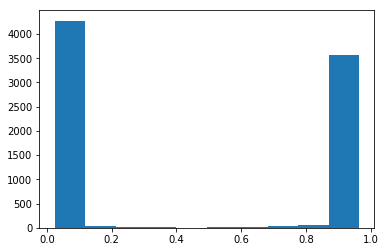

In [205]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.hist(Y_train)
None

In [36]:
# from snorkel import viewer
# idx = np.argsort(Y_train)
# viewer.SentenceNgramViewer(
#     candidates=[train_cands[i] for i in idx[:15]], 
#     session=session
# )

### Export Candidates to BRAT

In [220]:
%run ../src/brat.py
import dotenv
dotenv.load_dotenv('../env.sh')
collection_dir = osp.join(os.environ['REPO_DATA_DIR'], 'brat', 'viz', 'train_01')
corpus_docs_dir = osp.join(os.environ['DATA_DIR'], 'articles', 'corpus', 'corpus_00', 'links')
collection_dir, corpus_docs_dir

('/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/brat/viz/train_01',
 '/Users/eczech/data/research/hammer/nlp/20190311-pubmed-tcell-relation/articles/corpus/corpus_00/links')

In [230]:
def relation_type_fn(c, i, ents):
    proba = Y_train[i] 
    if proba < .2:
        return c.type + '_low'
    if proba < .8:
        return c.type + '_mid'
    return c.type + '_high'

def text_loader_fn(doc_id):
    with open(osp.join(corpus_docs_dir, doc_id + '.txt')) as fd:
        return fd.read()

In [231]:
bcol = snorkel_candidates_to_brat_collection(
    train_cands, InducingCytokine, text_loader_fn, relation_type_fn=relation_type_fn)

In [232]:
bcol.export(collection_dir, styles={
    'inducing_cytokine_low': 'color:red',
    'inducing_cytokine_mid': 'color:orange',
    'inducing_cytokine_high': 'color:green'
}, include_entity_text=False)